In [ ]:
!pip install virtualenv
!virtualenv XAIEnv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
created virtual environment CPython3.10.11.final.0-64 in 567ms
  creator CPython3Posix(dest=/content/XAIEnv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: Flask==2.2.3, Jinja2==3.1.2, MarkupSafe==2.1.2, Pillow==9.5.0, PyWavelets==1.4.1, Pygments==2.15.1, Werkzeug==2.2.3, ansi2html==1.8.0, asttokens==2.2.1, backcall==0.2.0, cachetools==5.3.0, captum==0.6.0, certifi==2023.5.7, charset_normalizer==3.1.0, click==8.1.3, cloudpickle==2.2.1, cmake==3.26.3, comm==0.1.3, contourpy==1.0.7, cycler==0.11.0, dash==2.10.0, dash_bootstrap_components==1.4.1, dash_core_components==2.0.0, dash_html_components==2.0.0, dash_table==5.0.0, debugpy==1.6.7, decorator==5.1.1, dill==0.3.6, executing==1.2.0, fastcore==1.5.29, filelock==3.12.0, fonttools==

In [ ]:
!pip install -q kaggle
from google.colab import files 
# files.upload()
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1KefgyStyr4xcEqlrJjlPevdH99jkcZ4J' -O kaggle.json
!cat kaggle.json

--2023-05-27 07:24:50--  https://drive.google.com/uc?export=download&id=1KefgyStyr4xcEqlrJjlPevdH99jkcZ4J
Resolving drive.google.com (drive.google.com)... 64.233.170.139, 64.233.170.102, 64.233.170.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.170.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ffuq3mm50vpe388hmopn5ledo48eutue/1685172225000/07295101801107701363/*/1KefgyStyr4xcEqlrJjlPevdH99jkcZ4J?e=download&uuid=8af1afa2-5ce4-4ace-adcd-a053a81680d6 [following]
--2023-05-27 07:24:51--  https://doc-0s-8c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ffuq3mm50vpe388hmopn5ledo48eutue/1685172225000/07295101801107701363/*/1KefgyStyr4xcEqlrJjlPevdH99jkcZ4J?e=download&uuid=8af1afa2-5ce4-4ace-adcd-a053a81680d6
Resolving doc-0s-8c-docs.googleusercontent.com (doc-0s-8c-docs.googleusercontent.com)... 74.125.24.132, 2404:6

# Explain Classification result from ResNet

In [ ]:
!source /content/XAIEnv/bin/activate; pip install -q numba torch captum torchvision quantus omnixai[vision] dash jupyter_dash dash_bootstrap_components scikit-learn==1.1.3 numpy==1.22.4 Pillow fastcore -I -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.8/543.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.0 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append("XAIEnv/lib/python3.10/site-packages")

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks -p /content/datasets/ --unzip

100% 4.50G/4.50G [03:57<00:00, 23.0MB/s]
100% 4.50G/4.50G [03:57<00:00, 20.3MB/s]


In [ ]:
!kaggle datasets download -d binhhuunguyen/xai-pretrained-blackbox  -p /content/datasets/ --unzip

 99% 252M/255M [00:18<00:00, 13.8MB/s]
100% 255M/255M [00:18<00:00, 14.6MB/s]


In [ ]:
import torch
import quantus
from captum.attr import (
    Saliency, # A baseline approach for computing input attribution
    GradientShap, 
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
    GuidedGradCam,
    GuidedBackprop,
    Saliency,
    LimeBase,
    FeatureAblation,
    Occlusion,
    LRP,
    visualization as viz
)
from PIL import Image
import torchvision
from torchvision import transforms
import json
import requests
from io import BytesIO
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from torchvision import models

warnings.filterwarnings('ignore')

%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cpu = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [ ]:
torch.manual_seed(123)
np.random.seed(123)

In [ ]:
resize_image = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(299),
])

transform = transforms.Compose([            
  transforms.ToTensor(),
  resize_image,
  transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
  )
])

mask_transform = transforms.Compose([            
  transforms.ToTensor(),
  resize_image,
])

# Setup datasets

In [ ]:
from torch.utils.data import Dataset

class PneumothoraxImageDataset(Dataset):
    def __init__(self, images, targets, masks, transform, mask_transform):
        self.masks = masks
        self.images = images
        self.targets = targets
        self.transform = transform
        self.mask_transform = mask_transform
        

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.asarray(Image.open(self.images[idx]).convert("RGB"))
        mask = np.asarray(Image.open(self.masks[idx]).convert("RGB"))
        label = self.targets[idx]
        if self.transform:
          image = self.transform(image)
        if self.mask_transform:
          mask = self.mask_transform(mask)
        return image, mask, label

In [ ]:
main_path = '/content/datasets/siim-acr-pneumothorax'
import os
import pandas as pd
# train_data = pd.read_csv(os.path.join(main_path, 'stage_1_train_images.csv'))
test_data = pd.read_csv(os.path.join(main_path, 'stage_1_test_images.csv'))
# Just load only abnormal cases
test_abnormal = test_data.loc[test_data.has_pneumo == 1]

# train_data['images'] = train_data['new_filename'].apply(lambda x: os.path.join(main_path, 'png_images', x))
# train_data['masks'] = train_data['new_filename'].apply(lambda x: os.path.join(main_path, 'png_masks', x))

test_abnormal['images'] = test_abnormal['new_filename'].apply(lambda x: os.path.join(main_path, 'png_images', x))
test_abnormal['masks'] = test_abnormal['new_filename'].apply(lambda x: os.path.join(main_path, 'png_masks', x))

images = test_abnormal['images'].tolist()
masks = test_abnormal['masks'].tolist()
targets = test_abnormal['has_pneumo'].tolist()

In [ ]:
dataset = PneumothoraxImageDataset(images, targets, masks, transform=transform, mask_transform=mask_transform)
ds_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

In [ ]:
x, mask, y = next(iter(ds_loader))
print(x.shape, mask.shape)

torch.Size([8, 3, 299, 299]) torch.Size([8, 3, 299, 299])


## UTIL FUNCS

### Bellow is the override of an visualization implementation due to the orginal version from the captum module cause bug when config matplotlib grid_b

In [ ]:
from matplotlib import cm, colors, pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.figure import Figure
from matplotlib.pyplot import axis, figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import ndarray
from enum import Enum
from typing import Any, Iterable, List, Optional, Tuple, Union


try:
    from IPython.display import display, HTML

    HAS_IPYTHON = True
except ImportError:
    HAS_IPYTHON = False


class ImageVisualizationMethod(Enum):
    heat_map = 1
    blended_heat_map = 2
    original_image = 3
    masked_image = 4
    alpha_scaling = 5


class TimeseriesVisualizationMethod(Enum):
    overlay_individual = 1
    overlay_combined = 2
    colored_graph = 3


class VisualizeSign(Enum):
    positive = 1
    absolute_value = 2
    negative = 3
    all = 4


def _prepare_image(attr_visual: ndarray):
    return np.clip(attr_visual.astype(int), 0, 255)


def _normalize_scale(attr: ndarray, scale_factor: float):
    assert scale_factor != 0, "Cannot normalize by scale factor = 0"
    if abs(scale_factor) < 1e-5:
        warnings.warn(
            "Attempting to normalize by value approximately 0, visualized results"
            "may be misleading. This likely means that attribution values are all"
            "close to 0."
        )
    attr_norm = attr / scale_factor
    return np.clip(attr_norm, -1, 1)


def _cumulative_sum_threshold(values: ndarray, percentile: Union[int, float]):
    # given values should be non-negative
    assert percentile >= 0 and percentile <= 100, (
        "Percentile for thresholding must be " "between 0 and 100 inclusive."
    )
    sorted_vals = np.sort(values.flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id = np.where(cum_sums >= cum_sums[-1] * 0.01 * percentile)[0][0]
    return sorted_vals[threshold_id]


def _normalize_attr(
    attr: ndarray,
    sign: str,
    outlier_perc: Union[int, float] = 2,
    reduction_axis: Optional[int] = None,
):
    attr_combined = attr
    if reduction_axis is not None:
        attr_combined = np.sum(attr, axis=reduction_axis)

    # Choose appropriate signed values and rescale, removing given outlier percentage.
    if VisualizeSign[sign] == VisualizeSign.all:
        threshold = _cumulative_sum_threshold(np.abs(attr_combined), 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.positive:
        attr_combined = (attr_combined > 0) * attr_combined
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    elif VisualizeSign[sign] == VisualizeSign.negative:
        attr_combined = (attr_combined < 0) * attr_combined
        threshold = -1 * _cumulative_sum_threshold(
            np.abs(attr_combined), 100 - outlier_perc
        )
    elif VisualizeSign[sign] == VisualizeSign.absolute_value:
        attr_combined = np.abs(attr_combined)
        threshold = _cumulative_sum_threshold(attr_combined, 100 - outlier_perc)
    else:
        raise AssertionError("Visualize Sign type is not valid.")
    return _normalize_scale(attr_combined, threshold)


def visualize_image_attr(
    attr: ndarray,
    original_image: Union[None, ndarray] = None,
    method: str = "heat_map",
    sign: str = "absolute_value",
    plt_fig_axis: Union[None, Tuple[figure, axis]] = None,
    outlier_perc: Union[int, float] = 2,
    cmap: Union[None, str] = None,
    alpha_overlay: float = 0.5,
    show_colorbar: bool = False,
    title: Union[None, str] = None,
    fig_size: Tuple[int, int] = (6, 6),
    use_pyplot: bool = True,
):
    r"""
    Visualizes attribution for a given image by normalizing attribution values
    of the desired sign (positive, negative, absolute value, or all) and displaying
    them using the desired mode in a matplotlib figure.

    Args:

        attr (numpy.ndarray): Numpy array corresponding to attributions to be
                    visualized. Shape must be in the form (H, W, C), with
                    channels as last dimension. Shape must also match that of
                    the original image if provided.
        original_image (numpy.ndarray, optional): Numpy array corresponding to
                    original image. Shape must be in the form (H, W, C), with
                    channels as the last dimension. Image can be provided either
                    with float values in range 0-1 or int values between 0-255.
                    This is a necessary argument for any visualization method
                    which utilizes the original image.
                    Default: None
        method (str, optional): Chosen method for visualizing attribution.
                    Supported options are:

                    1. `heat_map` - Display heat map of chosen attributions

                    2. `blended_heat_map` - Overlay heat map over greyscale
                       version of original image. Parameter alpha_overlay
                       corresponds to alpha of heat map.

                    3. `original_image` - Only display original image.

                    4. `masked_image` - Mask image (pixel-wise multiply)
                       by normalized attribution values.

                    5. `alpha_scaling` - Sets alpha channel of each pixel
                       to be equal to normalized attribution value.

                    Default: `heat_map`
        sign (str, optional): Chosen sign of attributions to visualize. Supported
                    options are:

                    1. `positive` - Displays only positive pixel attributions.

                    2. `absolute_value` - Displays absolute value of
                       attributions.

                    3. `negative` - Displays only negative pixel attributions.

                    4. `all` - Displays both positive and negative attribution
                       values. This is not supported for `masked_image` or
                       `alpha_scaling` modes, since signed information cannot
                       be represented in these modes.

                    Default: `absolute_value`
        plt_fig_axis (tuple, optional): Tuple of matplotlib.pyplot.figure and axis
                    on which to visualize. If None is provided, then a new figure
                    and axis are created.
                    Default: None
        outlier_perc (float or int, optional): Top attribution values which
                    correspond to a total of outlier_perc percentage of the
                    total attribution are set to 1 and scaling is performed
                    using the minimum of these values. For sign=`all`, outliers
                    and scale value are computed using absolute value of
                    attributions.
                    Default: 2
        cmap (str, optional): String corresponding to desired colormap for
                    heatmap visualization. This defaults to "Reds" for negative
                    sign, "Blues" for absolute value, "Greens" for positive sign,
                    and a spectrum from red to green for all. Note that this
                    argument is only used for visualizations displaying heatmaps.
                    Default: None
        alpha_overlay (float, optional): Alpha to set for heatmap when using
                    `blended_heat_map` visualization mode, which overlays the
                    heat map over the greyscaled original image.
                    Default: 0.5
        show_colorbar (bool, optional): Displays colorbar for heatmap below
                    the visualization. If given method does not use a heatmap,
                    then a colormap axis is created and hidden. This is
                    necessary for appropriate alignment when visualizing
                    multiple plots, some with colorbars and some without.
                    Default: False
        title (str, optional): Title string for plot. If None, no title is
                    set.
                    Default: None
        fig_size (tuple, optional): Size of figure created.
                    Default: (6,6)
        use_pyplot (bool, optional): If true, uses pyplot to create and show
                    figure and displays the figure after creating. If False,
                    uses Matplotlib object oriented API and simply returns a
                    figure object without showing.
                    Default: True.

    Returns:
        2-element tuple of **figure**, **axis**:
        - **figure** (*matplotlib.pyplot.figure*):
                    Figure object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same figure provided.
        - **axis** (*matplotlib.pyplot.axis*):
                    Axis object on which visualization
                    is created. If plt_fig_axis argument is given, this is the
                    same axis provided.

    Examples::

        >>> # ImageClassifier takes a single input tensor of images Nx3x32x32,
        >>> # and returns an Nx10 tensor of class probabilities.
        >>> net = ImageClassifier()
        >>> ig = IntegratedGradients(net)
        >>> # Computes integrated gradients for class 3 for a given image .
        >>> attribution, delta = ig.attribute(orig_image, target=3)
        >>> # Displays blended heat map visualization of computed attributions.
        >>> _ = visualize_image_attr(attribution, orig_image, "blended_heat_map")
    """
    # Create plot if figure, axis not provided
    if plt_fig_axis is not None:
        plt_fig, plt_axis = plt_fig_axis
    else:
        if use_pyplot:
            plt_fig, plt_axis = plt.subplots(figsize=fig_size)
        else:
            plt_fig = Figure(figsize=fig_size)
            plt_axis = plt_fig.subplots()

    if original_image is not None:
        if np.max(original_image) <= 1.0:
            original_image = _prepare_image(original_image * 255)
    elif ImageVisualizationMethod[method] != ImageVisualizationMethod.heat_map:
        raise ValueError(
            "Original Image must be provided for"
            "any visualization other than heatmap."
        )

    # Remove ticks and tick labels from plot.
    plt_axis.xaxis.set_ticks_position("none")
    plt_axis.yaxis.set_ticks_position("none")
    plt_axis.set_yticklabels([])
    plt_axis.set_xticklabels([])
    plt_axis.grid(visible=False)

    heat_map = None
    # Show original image
    if ImageVisualizationMethod[method] == ImageVisualizationMethod.original_image:
        assert (
            original_image is not None
        ), "Original image expected for original_image method."
        if len(original_image.shape) > 2 and original_image.shape[2] == 1:
            original_image = np.squeeze(original_image, axis=2)
        plt_axis.imshow(original_image)
    else:
        # Choose appropriate signed attributions and normalize.
        norm_attr = _normalize_attr(attr, sign, outlier_perc, reduction_axis=2)

        # Set default colormap and bounds based on sign.
        if VisualizeSign[sign] == VisualizeSign.all:
            default_cmap = LinearSegmentedColormap.from_list(
                "RdWhGn", ["red", "white", "green"]
            )
            vmin, vmax = -1, 1
        elif VisualizeSign[sign] == VisualizeSign.positive:
            default_cmap = "Greens"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.negative:
            default_cmap = "Reds"
            vmin, vmax = 0, 1
        elif VisualizeSign[sign] == VisualizeSign.absolute_value:
            default_cmap = "Blues"
            vmin, vmax = 0, 1
        else:
            raise AssertionError("Visualize Sign type is not valid.")
        cmap = cmap if cmap is not None else default_cmap

        # Show appropriate image visualization.
        if ImageVisualizationMethod[method] == ImageVisualizationMethod.heat_map:
            heat_map = plt_axis.imshow(norm_attr, cmap=cmap, vmin=vmin, vmax=vmax)
        elif (
            ImageVisualizationMethod[method]
            == ImageVisualizationMethod.blended_heat_map
        ):
            assert (
                original_image is not None
            ), "Original Image expected for blended_heat_map method."
            plt_axis.imshow(np.mean(original_image, axis=2), cmap="gray")
            heat_map = plt_axis.imshow(
                norm_attr, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha_overlay
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.masked_image:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display masked image with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                _prepare_image(original_image * np.expand_dims(norm_attr, 2))
            )
        elif ImageVisualizationMethod[method] == ImageVisualizationMethod.alpha_scaling:
            assert VisualizeSign[sign] != VisualizeSign.all, (
                "Cannot display alpha scaling with both positive and negative "
                "attributions, choose a different sign option."
            )
            plt_axis.imshow(
                np.concatenate(
                    [
                        original_image,
                        _prepare_image(np.expand_dims(norm_attr, 2) * 255),
                    ],
                    axis=2,
                )
            )
        else:
            raise AssertionError("Visualize Method type is not valid.")

    # Add colorbar. If given method is not a heatmap and no colormap is relevant,
    # then a colormap axis is created and hidden. This is necessary for appropriate
    # alignment when visualizing multiple plots, some with heatmaps and some
    # without.
    if show_colorbar:
        axis_separator = make_axes_locatable(plt_axis)
        colorbar_axis = axis_separator.append_axes("bottom", size="5%", pad=0.1)
        if heat_map:
            plt_fig.colorbar(heat_map, orientation="horizontal", cax=colorbar_axis)
        else:
            colorbar_axis.axis("off")
    if title:
        plt_axis.set_title(title)

    if use_pyplot:
        plt.show()

    return plt_fig, plt_axis

## Setup Blackbox & XAI methods

In [ ]:
checkpoint = torch.load('/content/datasets/inception_cp.pth')
blackbox = models.inception_v3()
blackbox.load_state_dict(checkpoint)
for parameter in blackbox.parameters():
    parameter.requires_grad = False
blackbox.eval().to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
sl = Saliency(blackbox)
guided_gc = GuidedGradCam(blackbox, blackbox.Mixed_7c)
gbp = GuidedBackprop(blackbox)
lrp = LRP(blackbox)
dls = DeepLiftShap(blackbox)
dl = DeepLift(blackbox)
gs = GradientShap(blackbox)
ig = IntegratedGradients(blackbox)
ablator = FeatureAblation(blackbox)
occlusion = Occlusion(blackbox)

# Generate Explainations

In [ ]:
rand_img_dist = torch.rand(x.shape).to(device)

In [ ]:
dataset_labels = { 0: 'normal', 1: 'Pneumothorax' }

In [ ]:
xai_methods = {
  "Saliency": { "method": sl , "options": {}},
  "GuidedGradCam": { "method": guided_gc, "options": {}},
  "GuidedBackprop": { "method": gbp, "options": {}},
  "LRP": { "method": lrp, "options": {}},
  # "DeepLiftShap": { "method": dls, "options": {}},
  # "DeepLift": { "method": dl, "options": {}},
  "GradientShap": { "method": gs, "options": { 'n_samples': 64, 'stdevs': 0.0001, 'baselines': rand_img_dist }},
  "IntegratedGradients": { "method": ig, "options": { 'n_steps' : 150 }, 'baselines': rand_img_dist },
  # "FeatureAblation": { "method": ablator, "options": {}},
  "Occlusion": { "method": occlusion, "options": { 'sliding_window_shapes': (3,8, 8), 'strides': (3, 4, 4)}}
}

In [ ]:
from tqdm import tqdm
import gc

def visualize_explain_of(xai_methods, x, mask, y, blackbox):
  with torch.no_grad():
    output = torch.nn.functional.softmax(blackbox(x), dim=1)
    _, indices = torch.topk(output, k=1, dim = 1)
  indices = torch.flatten(indices)
  num_methods = len(xai_methods.items())
  for idx, img in tqdm(enumerate(x)):
    target = indices[idx]
    if target.item() == 0:
      continue
    fig, axes = plt.subplots(1, num_methods + 1, figsize = (48, 6))
    axes[0].imshow(np.transpose(mask[idx].detach().numpy(), (1, 2, 0)))
    for method_idx, (method_name, parameters) in enumerate(xai_methods.items()):
      attributions = parameters["method"].attribute(img.unsqueeze(0), target=target, **parameters["options"])
      # Convert the compute attribution tensor into an image-like numpy array
      attribution = np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0))
      visualize_image_attr(attribution, np.transpose(img.cpu().detach().numpy(), (1, 2,0)), "blended_heat_map", sign="positive", title=method_name, use_pyplot=False, plt_fig_axis=(fig, axes[1 + method_idx]))
      torch.cuda.empty_cache()
      gc.collect()
    plt.show()

In [ ]:
# visualize_explain_of(xai_methods, x.to(device), mask, y, blackbox)

# Metrics to compare saliency masks

## Mathematical similarity measures

In [ ]:
import seaborn as sns
import scipy

In [ ]:
def get_explanation(xai_config, x, targets):
    xai_model = xai_config['method']
    options = xai_config['options']
    attribution = xai_model.attribute(x, target=targets, **options)
    return attribution

In [ ]:
def normalize(x):
    t = (x - np.min(x)) / (np.max(x) - np.min(x))
    return t / t.sum()

In [ ]:
with torch.no_grad():
    output = torch.nn.functional.softmax(blackbox(x.to(device)), dim=1)
    _, indices = torch.topk(output, k=1, dim = 1)
indices = torch.flatten(indices)

In [ ]:
attribution_saliency = get_explanation(xai_methods['Saliency'], x.to(device)[0], indices[0])

In [ ]:
sns.heatmap(normalize(attribution_saliency.sum(axis=0).mean(axis=0).cpu().detach().numpy()), annot=False, xticklabels=False, yticklabels=False)

In [ ]:
attribution_guidedgc = get_explanation(xai_methods['GradientShap'], x.to(device)[0], indices[0])

In [ ]:
sns.heatmap(normalize(np.abs(attribution_guidedgc.sum(axis=0).mean(axis=0).cpu().detach().numpy())), annot=False, xticklabels=False, yticklabels=False)

In [ ]:
sns.histplot(attribution_saliency.flatten().cpu().numpy())

In [ ]:
sns.histplot(attribution_guidedgc.flatten().cpu().numpy())

### Bhattacharrya Distance ([wiki](https://en.wikipedia.org/wiki/Bhattacharyya_distance))
Measure the similarity between two probability distributions $P$ and $Q$. Formula:
$$D(P, Q) = -\ln(BC(P, Q))$$
where:
$$BC(P, Q) = \sum_{x \in X}\sqrt{P(x)Q(x)}$$

In [ ]:
def bhattacharyya_distance(x, y):
    return -np.log(np.sum(np.sqrt(normalize(x) * normalize(y))))

In [ ]:
bhattacharyya_distance(attribution_saliency.cpu().numpy(), np.abs(attribution_guidedgc.cpu().numpy()))

In [ ]:
def hellinger_distance(x, y):
    return 1 / np.sqrt(2) * np.sqrt(np.sum((np.sqrt(normalize(x)) - np.sqrt(normalize(y))) ** 2))

## Averaging over test set

In [ ]:
import gc
def compute_mean_disagreement(method1, method2, x, indices, metric):
    gc.collect()
    torch.cuda.empty_cache()
    exp1 = []
    exp2 = []
    metrics = []
    e1 = get_explanation(method1, x, indices)
    e2 = get_explanation(method2, x, indices)
    metrics.append(metric(e1.cpu().detach().numpy(), e2.cpu().detach().numpy()))
    
    return np.array(metrics).mean()

In [ ]:
def compute_disagreement_heatmap(list_methods, x, blackbox, metric):
    size = len(list_methods)
    result = np.empty((size, size))
    with torch.no_grad():
        output = torch.nn.functional.softmax(blackbox(x), dim=1)
        _, indices = torch.topk(output, k=1, dim = 1)
    indices = torch.flatten(indices)

    for j in range(size):
        for i in range(size):
            if i > j:
                result[i, j] = compute_mean_disagreement(list_methods[i], list_methods[j], x, indices, metric)
            elif i == j:
                result[i, j] = 0
            else:
                result[i, j] = result[j, i]
    return result

In [ ]:
type(rand_)

torch.Tensor

In [ ]:
method_names = ['LRP', 'GradientShap', 'GuidedGradCam', 'GuidedBackprop', 'IntegratedGradients']
test_methods = list(map(lambda name: xai_methods[name], method_names))
heatmap = compute_disagreement_heatmap(test_methods, x.to(device), blackbox, hellinger_distance)
heatmap

OutOfMemoryError: ignored

In [ ]:
sns.heatmap(heatmap, annot=True, xticklabels=method_names, yticklabels=method_names)

### Kullback-Leibler divergence ([wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence))

Formula:
$$D_{KL}(P||Q) = \sum_{x \in X} P(x) \log{\frac{P(x)}{Q(x)}}$$

In [ ]:
def kl_divergence(x, y):
    return np.sum(scipy.special.kl_div(x, y))

In [ ]:
kl_divergence(normalize(attribution_guidedgc.mean(axis=2)), normalize(attribution_guidedbp.mean(axis=2)))

19.975594

In [ ]:
kl_divergence(normalize(attribution_guidedgc.mean(axis=2)), normalize(attribution_saliency.mean(axis=2)))

inf

In [ ]:
a = [attribution_saliency, attribution_guidedgc, attribution_guidedbp]


# Metrics from Quantus to measure the fit between XAI methods & blackbox model

## Prepare input data

In [ ]:
quantus.helpers.constants.available_methods_captum()

['GradientShap',
 'IntegratedGradients',
 'DeepLift',
 'DeepLiftShap',
 'InputXGradient',
 'Saliency',
 'FeatureAblation',
 'Deconvolution',
 'FeaturePermutation',
 'Lime',
 'KernelShap',
 'LRP',
 'Gradient',
 'Occlusion',
 'LayerGradCam',
 'GuidedGradCam',
 'LayerConductance',
 'LayerActivation',
 'InternalInfluence',
 'LayerGradientXActivation',
 'Control Var. Sobel Filter',
 'Control Var. Constant',
 'Control Var. Random Uniform']

In [ ]:
supported_methods = {
  "LRP": { },
  "GradientShap": { 'n_samples': 16, 'stdevs': 0.0001, 'baselines': rand_img_dist },
  "IntegratedGradients": { 'n_steps' : 50 , 'baselines': rand_img_dist },
  'GuidedGradCam': { 'gc_layer': blackbox.Mixed_7c },
  # Perturbation-based
  'KernelShap': {},
  # 'FeaturePermutation': {},
  "Occlusion": { 'sliding_window_shapes': (3, 16, 16), 'strides': (3, 4, 4)}
}

In [ ]:
from quantus.functions.explanation_func import explain as explain_func

In [ ]:
blackbox.to(cpu)
x_batch, y_batch, s_batch = x.cpu().numpy(), y.cpu().numpy(), torch.where(transforms.Grayscale(num_output_channels=1)(mask) > 0, 1.0, 0.).cpu().numpy()

## Axiomness metrics

In [ ]:
# ATOMIC 
# Create the completeness experiment.
completeness = quantus.Completeness(
    perturb_baseline="black",
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
)

# Call the metric instance to produce scores.
scores = { method: completeness(model=blackbox,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        explain_func=explain_func,
                        explain_func_kwargs={"method": method, **kwargs}) for method,kwargs in supported_methods.items()}
scores

## Faithfulness metrics

In [ ]:
infidelity = quantus.metrics.faithfulness.infidelity.Infidelity()
results = {method: infidelity(model=blackbox, 
                                  x_batch=x_batch,
                                  y_batch=y_batch,
                                  a_batch=None,
                                  device=device,
                                  explain_func=explain_func, 
                                  explain_func_kwargs={"method": method, **kwargs}) for method,kwargs in supported_methods.items()}

infidelity.plot(plot_func=None, results=results)

Warnings and information:
 (1) The Region Perturbation metric is likely to be sensitive to the choice of baseline value 'perturb_baseline', the patch size for masking 'patch_size' and number of regions to evaluate 'regions_evaluation'. Also, the current implementation only works for 3-dimensional (image) data. 
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Samek, Wojciech, et al. 'Evaluating the visualization of what a deep neural network has learned.' IEEE transactions on neural networks and learning systems 28.11 (2016): 2660-2673.
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



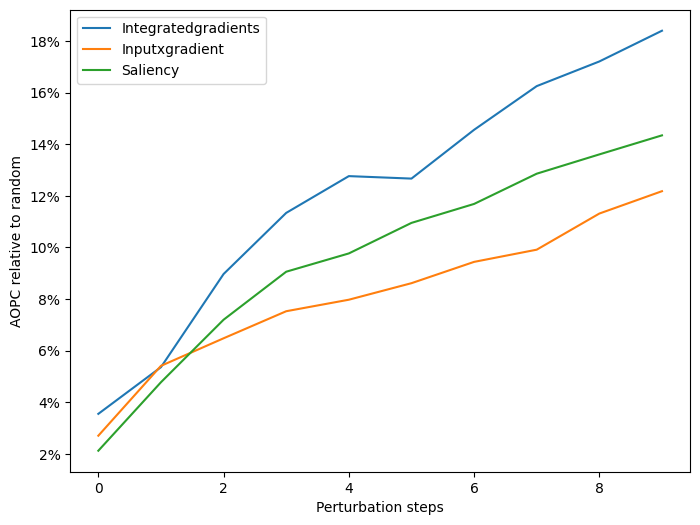

In [ ]:
# Create the region perturbation experiment.
region_perturb = quantus.RegionPerturbation(
    patch_size=14,
    regions_evaluation=10,
    perturb_baseline="uniform",  
    normalise=True,
)

# Call the metric instance to produce scores.
results = {method: region_perturb(model=blackbox, 
                                  x_batch=x_batch,
                                  y_batch=y_batch,
                                  a_batch=None,
                                  device=device,
                                  explain_func=explain_func, 
                                  explain_func_kwargs={"method": method, **kwargs}) for method,kwargs in supported_methods.items() }

region_perturb.plot(plot_func=None, results=results)

In [ ]:
# Create the pixel-flipping experiment.
pixel_flipping = quantus.PixelFlipping(
    features_in_step=x_batch.shape[3],
    perturb_baseline="black",
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
)
    
# Call the metric instance to produce scores.
scores = { method: pixel_flipping(model=blackbox,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        explain_func=explain_func,
                        device=device,
                        explain_func_kwargs={"method": method, **kwargs}) for method,kwargs in supported_methods.items()}
pixel_flipping.plot(plot_func=None, y_batch=y_batch, scores=scores)

In [ ]:
# Create the sensitivity-n experiment.
sensitivity_n = quantus.SensitivityN(
    features_in_step=x_batch.shape[3],
    n_max_percentage=0.8,
    similarity_func=quantus.similarity_func.correlation_pearson,
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
    perturb_baseline="uniform",  
    return_aggregate=False,
)
# Call the metric instance to produce scores.
results = { method: sensitivity_n(model=blackbox, 
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=None,
                        device=device,
                        explain_func=quantus.explain, 
                        explain_func_kwargs={"method": method, **kwargs}) for method,kwargs in supported_methods.items() }
                        

# Plot example!
sensitivity_n.plot(plot_func=None, results=results)

## Complexity Metrics

In [ ]:
complexity = quantus.Complexity()

results = { method: complexity(model=blackbox,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   explain_func=quantus.explain, 
   device=device,
   explain_func_kwargs={"method": method, **kwargs}) for method,kwargs in supported_methods.items()}

results

In [ ]:
consistancy = quantus.metrics.robustness.consistency.Consistency()
results = { method: consistancy(model=blackbox,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   explain_func=quantus.explain,
   device=device,
   explain_func_kwargs={"method": method, **kwargs}) for method,kwargs in supported_methods.items()}


## Localisation metrics

In [ ]:
auc = quantus.metrics.localisation.auc.AUC()
results = { method: auc(model=blackbox,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   explain_func=quantus.explain,
   device=device,
   explain_func_kwargs={"method": method, **kwargs}) for method,kwargs in supported_methods.items()}
results

Warnings and information:
 (1) The AUC metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' input as well as if absolute values 'abs' are taken of the attributions .  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Fawcett, Tom. 'An introduction to ROC analysis' Pattern Recognition Letters Vol 27, Issue 8, (2006).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



{'LRP': [0.5428358236416899,
  0.5073514838237989,
  0.5202437706409514,
  0.5172741643107533,
  0.49004877425327376,
  0.5291729102339005,
  0.5067536285363826,
  0.4963473395548769],
 'GradientShap': [0.4947647926556302,
  0.49484063271596535,
  0.5027443868822116,
  0.47678095446087587,
  0.491786685181539,
  0.5057932060258262,
  0.5060531659702809,
  0.49628165128970037],
 'IntegratedGradients': [0.5186582133777478,
  0.49435887527643685,
  0.4996525776834464,
  0.5151369929586591,
  0.47952897612065065,
  0.5027627109298645,
  0.5070789889024584,
  0.4970337520908852],
 'GuidedGradCam': [0.5118676632699918,
  0.4716891308410028,
  0.4763850713702346,
  0.4721897734163383,
  0.5400921943923426,
  0.44148912592221,
  0.5052706477382936,
  0.5024025678255536],
 'KernelShap': [0.46487659254139446,
  0.4843020980169119,
  0.4979160035507184,
  0.4893932903269159,
  0.4966494298731938,
  0.5062782086710085,
  0.5136472271851071,
  0.5056474467917702],
 'Occlusion': [0.5441276761015195,

In [ ]:
# {'LRP': [0.5428358236416899,
#   0.5073514838237989,
#   0.5202437706409514,
#   0.5172741643107533,
#   0.49004877425327376,
#   0.5291729102339005,
#   0.5067536285363826,
#   0.4963473395548769],
#  'GradientShap': [0.4947647926556302,
#   0.49484063271596535,
#   0.5027443868822116,
#   0.47678095446087587,
#   0.491786685181539,
#   0.5057932060258262,
#   0.5060531659702809,
#   0.49628165128970037],
#  'IntegratedGradients': [0.5186582133777478,
#   0.49435887527643685,
#   0.4996525776834464,
#   0.5151369929586591,
#   0.47952897612065065,
#   0.5027627109298645,
#   0.5070789889024584,
#   0.4970337520908852],
#  'GuidedGradCam': [0.5118676632699918,
#   0.4716891308410028,
#   0.4763850713702346,
#   0.4721897734163383,
#   0.5400921943923426,
#   0.44148912592221,
#   0.5052706477382936,
#   0.5024025678255536],
#  'KernelShap': [0.46487659254139446,
#   0.4843020980169119,
#   0.4979160035507184,
#   0.4893932903269159,
#   0.4966494298731938,
#   0.5062782086710085,
#   0.5136472271851071,
#   0.5056474467917702],
#  'Occlusion': [0.5441276761015195,
#   0.4233042564462611,
#   0.7403368048083724,
#   0.6414662940403795,
#   0.6430569055983308,
#   0.5323578277575485,
#   0.7214574332867193,
#   0.5748655091599819]}

# Dashboard from OmniXAI

In [ ]:
from omnixai.preprocessing.image import Resize
from PIL import Image
from omnixai.data.image import Image as OmniImage

def prepare_RBG_from_uri(uri):
  imgResponse = requests.get(uri)
  img = OmniImage(Image.open(BytesIO(imgResponse.content)).convert('RGB'))
  return img

def prepare_RBG_for_explain(uris):
  batch = np.concatenate(
    [Resize((224,224)).transform(prepare_RBG_from_uri(uri)).to_numpy() for uri in uris]
  );
  return batch

x_batch = prepare_RBG_for_explain(uris);
x_batch.shape


In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [ ]:
from omnixai.explainers.vision import VisionExplainer
from omnixai.visualization.dashboard import Dashboard

# output = torch.nn.functional.softmax(blackbox(input), dim=1)
#     _, target = torch.topk(output[0], k=1, dim = 0)

preprocess = lambda ims: torch.stack([transform(im.to_pil()) for im in ims]).to(device)
postprocess = lambda logits: torch.nn.functional.softmax(logits, dim=1)

explainer = VisionExplainer(
    explainers=["lime", "gradcam", "ig", "ce", "feature_visualization"],
    mode="classification",
    model=blackbox,                   # An image classification model, e.g., ResNet50
    preprocess=preprocess,         # The preprocessing function
    postprocess=postprocess,       # The postprocessing function
    params={
        # Set the target layer for GradCAM
        "gradcam": {"target_layer": blackbox.layer4[-1]},
        # Set the objective for feature visualization
        "feature_visualization": 
          {"objectives": [{"layer": blackbox.layer4[-3], "type": "channel", "index": list(range(6))}]},
        "ce": {"binary_search_steps": 2, "num_iterations": 20},
    },
)


img = OmniImage(data=x_batch,batched=True)

# Generate explanations of GradCAM, LIME, IG and CE
local_explanations = explainer.explain(img)
# Generate explanations of feature visualization
global_explanations = explainer.explain_global()
# Launch the dashboard
dashboard = Dashboard(
    instances=img,
    local_explanations=local_explanations,
    global_explanations=global_explanations
)
dashboard.show()